In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import shutil

In [2]:
# Import national data
df_ita = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [3]:
df_ita.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [49]:
df_ita

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,NaN,1,...,NaN,NaN,229,4324,NaN,NaN,0.052960,NaN,02-24,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,90.0,1,...,NaN,NaN,322,8623,NaN,NaN,0.037342,0.020935,02-25,1.407240
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,74.0,3,...,NaN,NaN,400,9587,NaN,NaN,0.041723,0.076763,02-26,1.237942
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,203.0,45,...,NaN,NaN,650,12014,NaN,NaN,0.054104,0.083642,02-27,1.527273
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,233.0,46,...,NaN,NaN,888,15695,NaN,NaN,0.056579,0.063298,02-28,1.396259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2020-11-06T17:00:00,ITA,24005,2515,26520,472598,499118,26770,26770.0,322925,...,562010.0,300671.0,862681,16951896,10290151.0,NaN,0.050890,0.114282,11-06,1.056674
257,2020-11-07T17:00:00,ITA,25109,2634,27743,504793,532536,33418,33418.0,328891,...,583660.0,318830.0,902490,17183569,10427797.0,NaN,0.052521,0.144246,11-07,1.066954
258,2020-11-08T17:00:00,ITA,26440,2749,29189,529447,558636,26100,26100.0,335074,...,601403.0,333701.0,935104,17374713,10547046.0,NaN,0.053820,0.136546,11-08,1.049011
259,2020-11-09T17:00:00,ITA,27636,2849,30485,542849,573334,14698,14698.0,345289,...,614843.0,345530.0,960373,17522438,10635747.0,NaN,0.054808,0.099496,11-09,1.026311


### Quanto passa da contagio a decesso? 13 giorni

In [34]:
df = df_ita[["nuovi_positivi","deceduti"]].copy()
df["nuovi_deceduti"] = df.deceduti - df.deceduti.shift(1)
for i in range(1,60):
    new_col = f"np_t_minus_{i}"
    df[new_col] = df.nuovi_positivi.shift(i)
df.drop(columns=["nuovi_positivi","deceduti"], inplace=True)
for col in df.columns:
    df[col] = df[col].apply(lambda x: x if x>0 else 0)
df = df.iloc[-100:]

In [47]:
df.corr()["nuovi_deceduti"].sort_values(ascending=False)[0:10]

nuovi_deceduti    1.000000
np_t_minus_13     0.972370
np_t_minus_6      0.970867
np_t_minus_12     0.962083
np_t_minus_11     0.959189
np_t_minus_5      0.957506
np_t_minus_14     0.954539
np_t_minus_20     0.954511
np_t_minus_7      0.952803
np_t_minus_9      0.952161
Name: nuovi_deceduti, dtype: float64

### Dopo quanto tempo i nuovi contagi si ripercuotono su terapie intensive? 3 giorni

In [3]:
df = df_ita[["nuovi_positivi","terapia_intensiva"]].copy()
for i in range(1,60):
    new_col = f"np_t_minus_{i}"
    df[new_col] = df.nuovi_positivi.shift(i)
df.drop(columns=["nuovi_positivi"], inplace=True)
for col in df.columns:
    df[col] = df[col].apply(lambda x: x if x>0 else 0)
df = df.iloc[-100:]

### Modello lineare per il numero di morti

In [39]:
df = df_ita[["nuovi_positivi","deceduti", "tamponi"]].copy()
df["nuovi_deceduti"] = df.deceduti - df.deceduti.shift(1)
df["nuovi_positivi_t-13"] = df.nuovi_positivi.shift(13)
df["ratio_positivi_t-13"] = df["nuovi_positivi_t-13"]/df.tamponi.shift(13)*100000
df.drop(columns=["nuovi_positivi","deceduti"], inplace=True)
for col in df.columns:
    df[col] = df[col].apply(lambda x: x if x>0 else 0)
#df["constant"] = 1
df = df.iloc[-100:]

In [40]:
df

,tamponi,nuovi_deceduti,nuovi_positivi_t-13,ratio_positivi_t-13
162,6984589,5.0,282.0,4.437639
163,7041040,10.0,306.0,4.770040
164,7099713,6.0,252.0,3.895878
165,7158909,3.0,275.0,4.217762
166,7212207,13.0,255.0,3.886856
...,...,...,...,...
257,17183569,425.0,21273.0,145.168535
258,17374713,331.0,17012.0,115.111707
259,17522438,356.0,21994.0,147.086695
260,17740196,580.0,24991.0,164.934908


In [41]:
import numpy as np
from statsmodels.api import OLS

In [42]:
df_train = df.iloc[:-7]
lm = OLS(df_train["nuovi_deceduti"],df_train[["nuovi_positivi_t-13", "ratio_positivi_t-13"]]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         nuovi_deceduti   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              784.1
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                    4.29e-58
Time:                        20:39:56   Log-Likelihood:                         -416.88
No. Observations:                  93   AIC:                                      837.8
Df Residuals:                      91   BIC:                                      842.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
nuovi_positivi_t-13     0.0361      0.005      7.362      0.000       0.026       0.046
ratio_positivi_t-13    -1.8366      0.639     -2.875      0.005      -3.105      -0.568
==============================================================================
Omnibus:                      119.927   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3231.470
Skew:                           4.207   Prob(JB):                         0.00
Kurtosis:                      30.625   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
df["predetti_nuovi_deceduti"] = round(lm.predict(df[["nuovi_positivi_t-13", "ratio_positivi_t-13"]]))
df

,tamponi,nuovi_deceduti,nuovi_positivi_t-13,ratio_positivi_t-13,predetti_nuovi_deceduti
162,6984589,5.0,282.0,4.437639,2.0
163,7041040,10.0,306.0,4.770040,2.0
164,7099713,6.0,252.0,3.895878,2.0
165,7158909,3.0,275.0,4.217762,2.0
166,7212207,13.0,255.0,3.886856,2.0
...,...,...,...,...,...
257,17183569,425.0,21273.0,145.168535,501.0
258,17374713,331.0,17012.0,115.111707,403.0
259,17522438,356.0,21994.0,147.086695,524.0
260,17740196,580.0,24991.0,164.934908,599.0


In [55]:
df_pred = df_ita[["data", "nuovi_positivi", "deceduti", "tamponi"]]
df_pred["nuovi_deceduti"] = df_pred.deceduti - df_pred.deceduti.shift(1)
df_pred["ratio_positivi"] = df_pred["nuovi_positivi"]/df_pred.tamponi*100000
df_pred["deceduti_in_13"] = round(lm.predict(df_pred[["nuovi_positivi", "ratio_positivi"]]))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A val

In [56]:
df_pred.tail(15)

,data,nuovi_positivi,deceduti,tamponi,nuovi_deceduti,ratio_positivi,deceduti_in_13
247,2020-10-28T17:00:00,24991,37905,15152038,205.0,164.934908,599.0
248,2020-10-29T17:00:00,26831,38122,15353490,217.0,174.755056,648.0
249,2020-10-30T17:00:00,31084,38321,15568575,199.0,199.658607,756.0
250,2020-10-31T17:00:00,31758,38618,15784461,297.0,201.197874,777.0
251,2020-11-01T17:00:00,29907,38826,15967918,208.0,187.294298,736.0
252,2020-11-02T17:00:00,22253,39059,16103649,233.0,138.186072,550.0
253,2020-11-03T17:00:00,28244,39412,16285936,353.0,173.425709,701.0
254,2020-11-04T17:00:00,30550,39747,16497767,335.0,185.176576,763.0
255,2020-11-05T17:00:00,34505,40192,16717651,445.0,206.398614,867.0
256,2020-11-06T17:00:00,37809,40638,16951896,446.0,223.036998,955.0


In [4]:
# Feature engineering
df_ita["prcn_tamponi_positivi_overall"] = df_ita["totale_casi"]/df_ita["tamponi"]
df_ita["prcn_tamponi_positivi_daily"] = df_ita["variazione_totale_positivi"]/(df_ita["tamponi"] - df_ita["tamponi"].shift(1))
df_ita['reference_day'] = df_ita.data.apply(lambda x: x[5:10])
df_ita['nuovi_positivi'] = df_ita['totale_positivi'] - df_ita["totale_positivi"].shift(1)
df_ita["growth_rate"] = df_ita["totale_positivi"]/df_ita["totale_positivi"].shift(1)

In [6]:
df_ita.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note,prcn_tamponi_positivi_overall,prcn_tamponi_positivi_daily,reference_day,growth_rate
215,2020-09-26T17:00:00,ITA,2746,247,2993,45600,48593,875,875.0,223693,...,245365.0,62739.0,308104,10999350,6646695.0,NaN,0.028011,0.008382,09-26,1.018337
216,2020-09-27T17:00:00,ITA,2846,254,3100,46518,49618,1025,1025.0,224417,...,246156.0,63714.0,309870,11087064,6700432.0,NaN,0.027949,0.011686,09-27,1.021094
217,2020-09-28T17:00:00,ITA,2977,264,3241,47082,50323,705,705.0,225190,...,246842.0,64522.0,311364,11138173,6732777.0,NaN,0.027955,0.013794,09-28,1.014209
218,2020-09-29T17:00:00,ITA,3048,271,3319,47311,50630,307,307.0,226506,...,247628.0,65383.0,313011,11228358,6786395.0,NaN,0.027877,0.003404,09-29,1.006101
219,2020-09-30T17:00:00,ITA,3047,280,3327,47936,51263,633,633.0,227704,...,248613.0,66248.0,314861,11333922,6848755.0,NaN,0.027780,0.005996,09-30,1.012502


## Parametri

In [7]:
# Giorni con decreti:
day_decreti = []#'03-04', '03-08', '03-09', '03-11', '03-22']
fase2 = ['05-04']
fase3 = ['06-03']

# Intervallo etichette giorni
n_label = 14

## Grafici

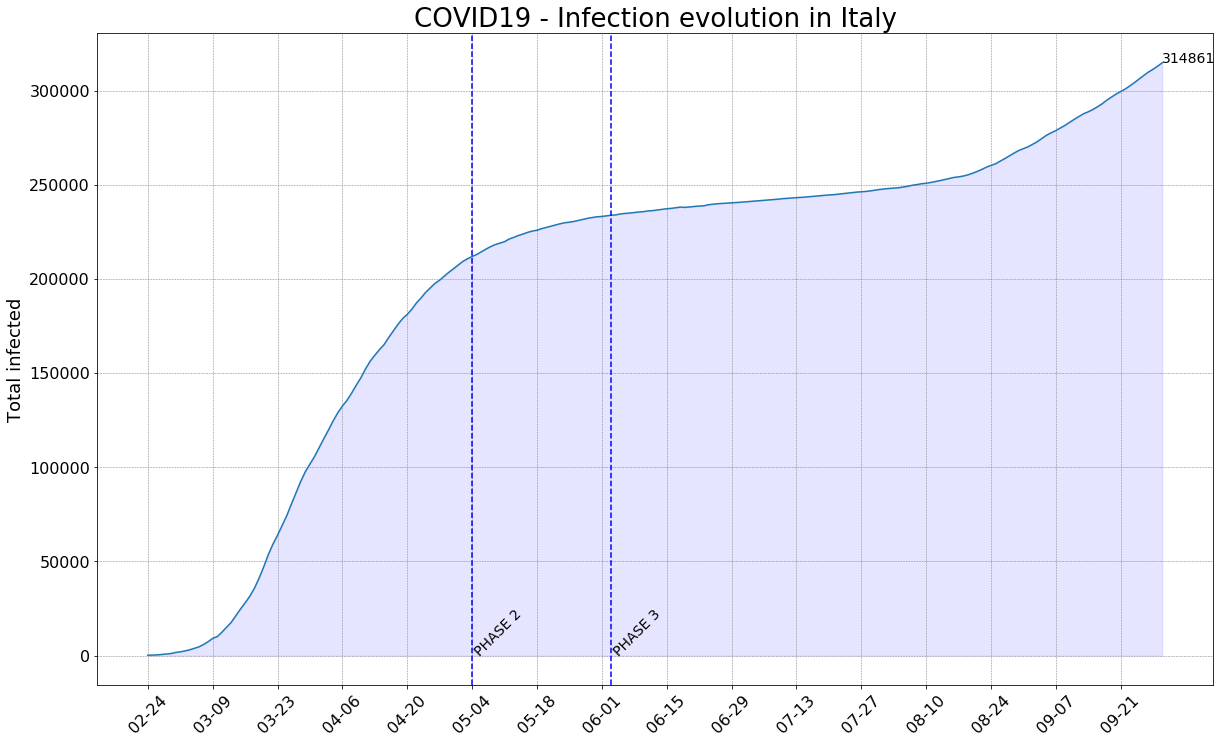

In [8]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_casi",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='totale_casi', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Total infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_casi[len(df_ita)-1],
         df_ita.totale_casi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/infection_evolution_ita.png")
plt.show()

In [9]:
def get_trend(series):
    from pandas import datetime
    from sklearn.linear_model import LinearRegression
    from matplotlib import pyplot
    import numpy
     
    def parser(x):
        return datetime.strptime('190'+x, '%Y-%m')
     
    series = series.dropna()
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = numpy.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    return trend

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


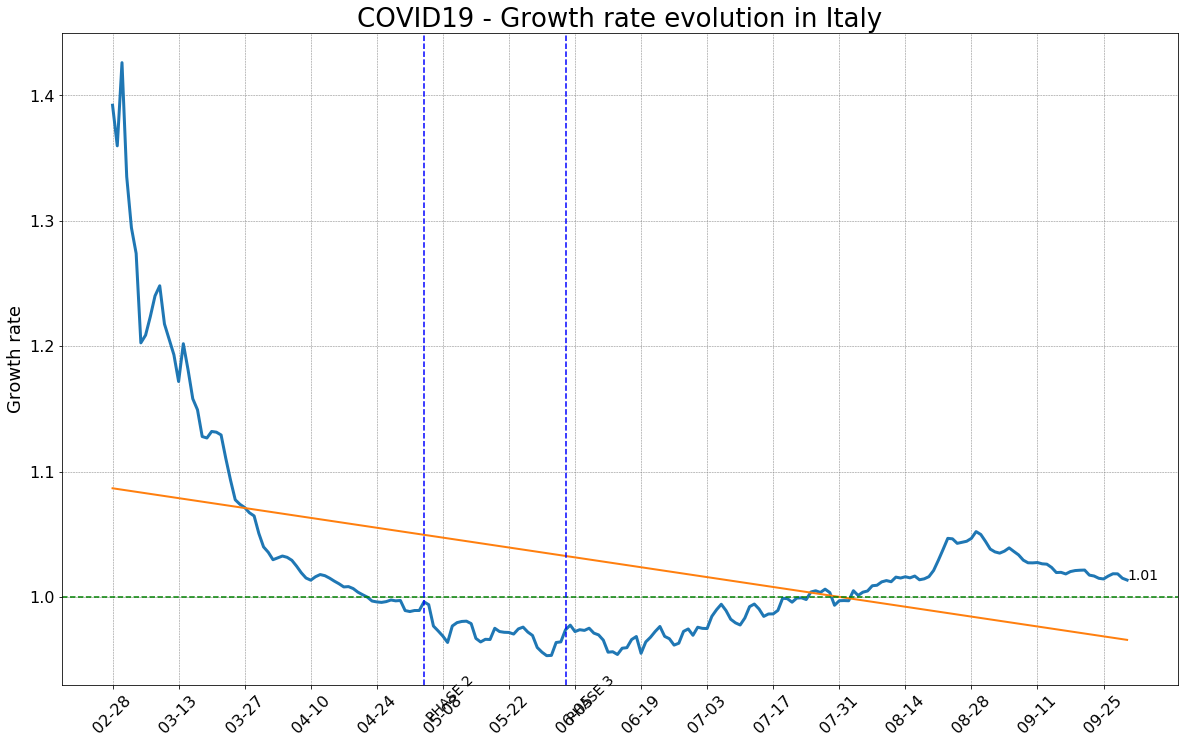

In [10]:
# Generate plot
df_gr = df_ita[["reference_day", "growth_rate"]].dropna().copy()
df_gr["growth_rate"] = df_gr.growth_rate.rolling(window=4).mean()
df_gr.dropna(inplace=True)
df_gr["trend"] = get_trend(df_gr["growth_rate"])
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="growth_rate",
                  data=df_gr, lw=3)
ax = sns.lineplot(x="reference_day", y="trend",
                  data=df_gr, lw=2)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('Growth rate', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Growth rate evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
#plt.ylim(bottom=0, top=1.6)
ax.axhline(1, ls='--', color='green', lw=1.5)
plt.text(df_gr.reference_day[len(df_ita)-1], 
         df_gr.growth_rate[len(df_ita)-1],
         round(df_gr.growth_rate[len(df_ita)-1],2), fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .9,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .9,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/growth_rate_ita.png")
plt.show()

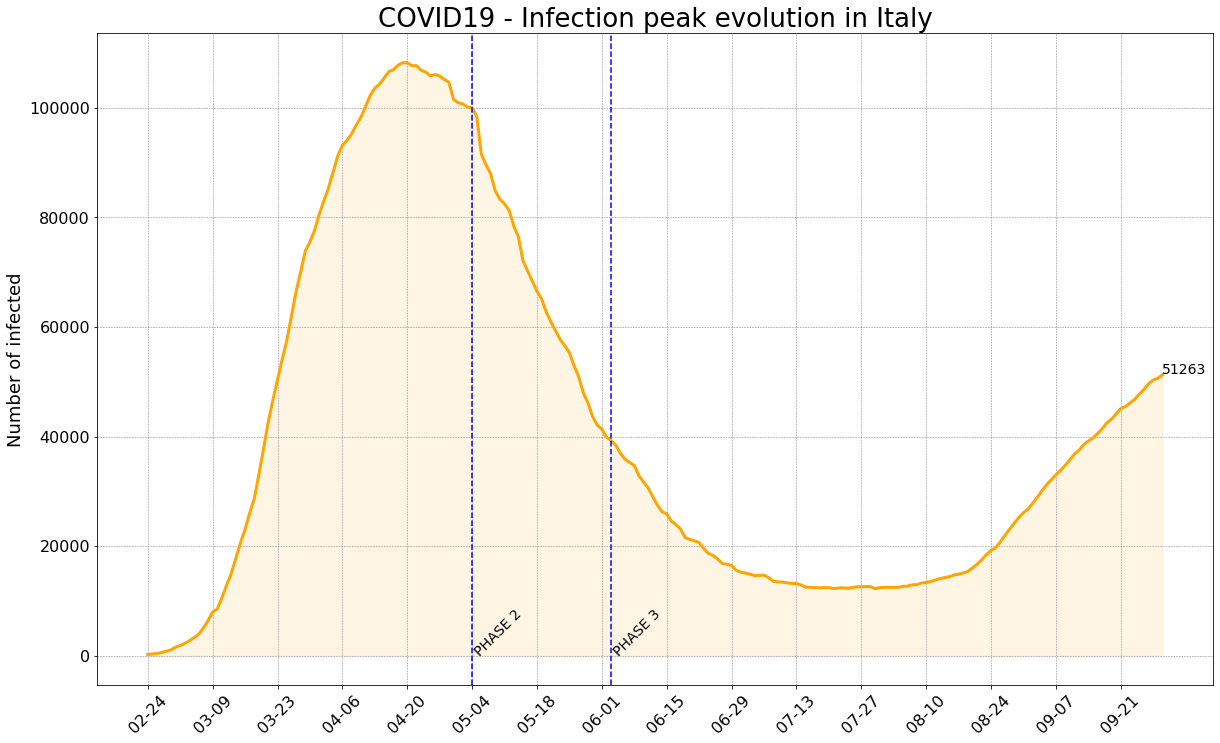

In [11]:
# What does the peak look like?
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="totale_positivi",
                  data=df_ita, lw=3, color='orange')
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.fill_between(x='reference_day', y1='totale_positivi', y2=0 ,data=df_ita, color='orange', alpha=.1)
plt.ylabel('Number of infected', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Infection peak evolution in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.totale_positivi[len(df_ita)-1]+144,
         df_ita.totale_positivi[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .5,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/peak_evolution_ita.png")
plt.show()

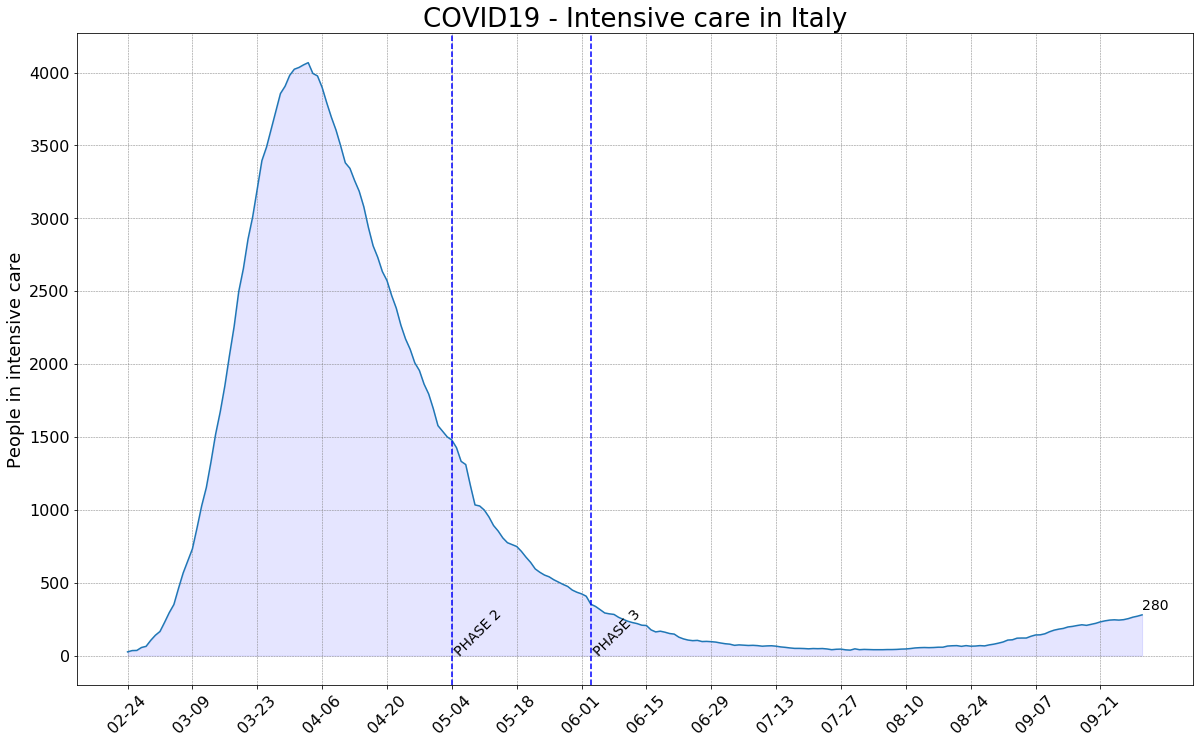

In [12]:
# Generate plot
plt.figure(figsize=(20,12))
ax = sns.lineplot(x="reference_day", y="terapia_intensiva",
                  data=df_ita)
plt.fill_between(x='reference_day', y1='terapia_intensiva', y2=0 ,data=df_ita, color='blue', alpha=.1)
plt.grid(color='grey', linestyle='--', linewidth=.5, which='both')
plt.ylabel('People in intensive care', fontsize=18)
plt.xlabel('')
plt.title('COVID19 - Intensive care in Italy', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45)
plt.text(df_ita.reference_day[len(df_ita)-1], 
         df_ita.terapia_intensiva[len(df_ita)-1]+34,
         df_ita.terapia_intensiva[len(df_ita)-1], fontsize=14)
for day in day_decreti:
    ax.axvline(day, ls='--', color='red', lw=1.5)
    plt.text(day, .3,'DPCM', fontsize=14, rotation=45)
for day in fase2:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 2', fontsize=14, rotation=45)
for day in fase3:
    ax.axvline(day, ls='--', color='blue', lw=1.5)
    plt.text(day, .3,'PHASE 3', fontsize=14, rotation=45)
ax.set_xticks(ax.get_xticks()[::n_label])
plt.savefig(f"{dir_path}/intensive_care_ita.png")
plt.show()